<a href="https://colab.research.google.com/github/Ruanvans/GAN-time-series-implementation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following code will serve as the GAN network employed in my disseratation**

**Ruan van Schalkwyk**                                                            
**6459265**

**Supervisor: Yoachu Jin** 

**University of Surrey Computer Science** 


# **Necessary libraries and tools**

In [1]:
#libraries and tools necessary to import and visualize data
from google.colab import files
import pandas as pd
import requests 
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot

#libraries needed to preprocess the data
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

#libraries to create the models and visualize models
from keras.models import Sequential 
from keras.layers import Dense 
from keras.utils.vis_utils import plot_model
import numpy as np
from numpy import hstack 
from numpy import zeros 
from numpy import ones 
from numpy.random import randn 
from numpy.random import rand
import random
from keras.layers import Reshape, Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D



#libraries needed to create the Wasserstein GAN 
from keras import backend
from keras.optimizers import RMSprop
from keras.constraints import Constraint
from keras.initializers import RandomNormal

Using TensorFlow backend.


# **Data Collection**

The below cells of code are used to retrieve the data used within the project from the AlphaVantage API. The first cell works directly with the API and the second cell is used to format the data into the correct format (csv file) and then downloads the data so that it can be cleaned for further use

In [0]:
Key = 'WS42XHAOBGP40QEM'
sym= 'AAPL'

fname = 'daily' + sym +'.csv'

if not os.path.isfile(fname):
  v = urllib.request.urlopen("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + sym + "&apikey=" + Key + "&outputsize=full&datatype=csv").read()
  with open(fname, 'wb') as f:
    f.write(v)

In [0]:
df = pd.read_csv(fname)
df = pd.DataFrame(df)
df.to_csv('Apple.csv')
files.download('Apple.csv')
df

,timestamp,open,high,low,close,volume
0,2020-05-11,308.10,317.05,307.24,315.01,36486561
1,2020-05-08,305.64,310.35,304.29,310.13,33511985
2,2020-05-07,303.22,305.17,301.97,303.74,28803764
3,2020-05-06,300.46,303.24,298.87,300.63,35583438
4,2020-05-05,295.06,301.00,294.46,297.56,36937795
...,...,...,...,...,...,...
5027,2000-05-16,104.52,109.06,102.75,105.69,3932600
5028,2000-05-15,108.06,108.06,100.12,101.00,6061900
5029,2000-05-12,106.00,110.50,104.77,107.62,2740300
5030,2000-05-11,101.37,104.25,99.00,102.81,4462000


# **Data preprocessign**

Below cell provides convenience when uploading the data as it is faster to upload a zip file with all the cleaned data to google colab than to upload individual files. 

In [2]:
!unzip 'final_data.zip'

Archive:  final_data.zip
  inflating: boeing.csv              
  inflating: Intercontinental.csv    
  inflating: JPMorgan.csv            
  inflating: Microsoft.csv           
  inflating: pfizer.csv              


importation of the data from the cleaned csv files

In [0]:
intercontinental = pd.read_csv('Intercontinental.csv', parse_dates=True, index_col=0)
boeing = pd.read_csv('boeing.csv', parse_dates=True, index_col=0)
jpmorgan = pd.read_csv('JPMorgan.csv', parse_dates=True, index_col=0)
microsoft = pd.read_csv('Microsoft.csv', parse_dates=True, index_col=0)
pfizer = pd.read_csv('pfizer.csv', parse_dates=True, index_col=0)

In [0]:
Intercontinental = intercontinental['open']
Boeing = boeing['open']
JPmorgan = jpmorgan['open']
Microsoft = microsoft['open']
Pfizer = pfizer['open']

# **Visualisation of the chosen stocks**

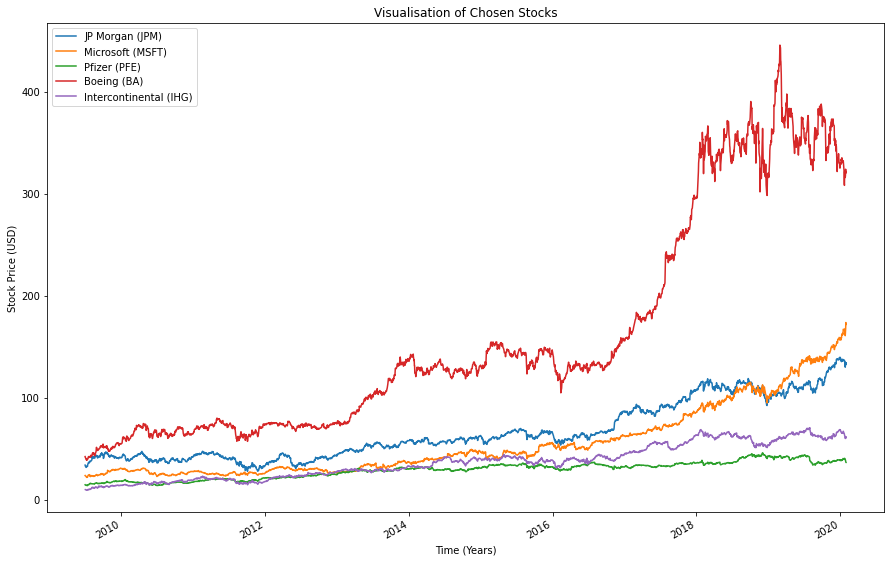

In [0]:
plt.figure(figsize=(15,10))
JPmorgan.plot(label = 'JP Morgan (JPM)')
Microsoft.plot(label = 'Microsoft (MSFT)')
Pfizer.plot(label = 'Pfizer (PFE)')
Boeing.plot(label= 'Boeing (BA)')
Intercontinental.plot(label = 'Intercontinental (IHG)')
plt.title(label = 'Visualisation of Chosen Stocks')
plt.legend(loc='upper left')
plt.ylabel(ylabel= 'Stock Price (USD)')
plt.xlabel(xlabel= 'Time (Years)')
plt.savefig('stocks.png', bbox_inches ='tight')
files.download('stocks.png')
plt.show()

In [5]:
normalizer = MinMaxScaler()
x = Intercontinental.values.reshape(-1,1) 
normalized = normalizer.fit_transform(x)
un_normalized = normalizer.inverse_transform(normalized)
print(normalized)
print('')
print(Intercontinental)
print('')
print(un_normalized)

[[0.85420408]
 [0.83461224]
 [0.8475102 ]
 ...
 [0.00391837]
 [0.0037551 ]
 [0.00946939]]

timestamp
2020-01-31    61.99
2020-01-30    60.79
2020-01-29    61.58
2020-01-28    60.40
2020-01-27    60.42
              ...  
2009-07-09     9.85
2009-07-08     9.67
2009-07-07     9.91
2009-07-06     9.90
2009-07-02    10.25
Name: open, Length: 2664, dtype: float64

[[61.99]
 [60.79]
 [61.58]
 ...
 [ 9.91]
 [ 9.9 ]
 [10.25]]


# **Vanilla GAN**

## **MLP implementation**

## **GAN development**

**The three methods below are used to create examples to train and test the GAN architectures**

In [0]:
"""
this method is used when stress testing the gan on various mathematical functions
the value of of x_func can be replaced with any function to test the working of
the GAN architecture. The examples created here are used to train the discriminator 
to recognise what real examples look like
"""

def real_examples(n): 
#this line creates the random numbers that will be used within the x_func variable
  X_var = -2.5+(2.5-(-2.5))*rand(1,n)
  #X_var = np.arange(0, n*0.1,0.1)
#the x_func variable is used to model the mathematical function we wish to generate 
  X_func = X_var * X_var * X_var
  #X_func = (X_var + 3)*((X_var -2)**2)*((X_var+1)**3)
  #X_func = np.sin(X_var)
#the variables have to be reshaped so that they may be stacked into an array 
  X_var = X_var.reshape(n,1)
  X_func = X_func.reshape(n,1)
#hstack is used to ensure that the x_var corresponds to x_func 
  X = hstack((X_var,X_func))
#we generate labels for the real examples in the form of ones
  y = ones((n,1))
  return X,y

"""
the method below creates the points in latent space that will serve as the input 
to the generator model. The literature on GANs suggest that the best type of input 
for a GAN model's generator are random points from a gaussian distribution. 
"""
def latent_points(latent, n):
#we use randn here as it returns random variables from a normal gaussian distribution 
  input_var = randn(latent*n)
  input_var = input_var.reshape(n,latent)
  return input_var
"""
we use the generator in this method to construct fake examples of the data made 
up from random generations. it takes in the generator model and latent points to
generate the fake examples. 
"""
def fake_examples(gen, latent,n):
  input_var = latent_points(latent, n)
  X = gen.predict(input_var)
  y = zeros((n,1))
  return X,y

In [0]:
"""
this method is used to systematically visualize the performance of the GAN model 
by evaluating the accuracy of the discriminator on both real and fake examples 
it also visualizes the generated samples produced by the generator along with 
the real samples. 
"""
def snapshot(epoch, gen, dis, latent, n=100):
#generate real samples and their corresponding labels 
  example_real, label_real = real_examples(n)

#generate fake samples and their corresponding labels 
  example_fake, label_fake = fake_examples(gen, latent, n)

#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
"""
creates a visualization of the loss of the discriminator on both real and fake 
samples as well as the loss of the gan model
"""
def loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake):
  plt.plot(gan_loss, color='red',label='GAN loss')
  plt.plot(discriminator_loss_real, color='green', label='Discriminator Loss Real Samples')
  plt.plot(discriminator_loss_fake, color='blue', label='Discriminator Loss Fake Samples')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss Value')
  plt.legend(loc='upper right')
  plt.savefig('Loss visualisation')
  plt.show()

In [0]:
#method used to create the architecture of the generator 
def gen_method(latent, num_outputs=2):
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  return model
  #Generator model required for GAN model 2
  """
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))


   model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  #Generator model required for GAN model 3
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  
#method to create the architecture of the discriminator 
def dis_method(num_inputs=2):
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model
  #Discriminator model required for GAN model 2
  """
  model.add(Dense(40, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam')

  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam')
  """
  #Discriminator model required for GAN model 3
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam')
  """
  
 
#method to used to combine the generator and discriminator architectures into a GAN
def gan_method(gen, dis):
  #within the GAN the discriminator is made untrainable as it is fit indepently
  dis.trainable =False
  model = Sequential()
  model.add(gen)
  model.add(dis)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model


In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_method(gen_architecture, dis_architecture, gan_architecture, latent):
  epochs=50000
  batch_size=150
  snapshot_value=5000
  #creation of lists to store the losses for the gan and discriminator on both the fake and real samples
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  #a loop to iterate through each epoch 
  for i in range(epochs):
    #creation of the real and fake examples
    example_real, label_real = real_examples(int(batch_size/2))
    example_fake, label_fake = fake_examples(gen_architecture, latent, int(batch_size/2))
    #training the discriminator on the real and fake examples and storing the the losses 
    discriminator_history_real = dis_architecture.train_on_batch(example_real, label_real)
    discriminator_history_fake = dis_architecture.train_on_batch(example_fake, label_fake)
    #appending the losses form each epoch to the previously created lists 
    discriminator_loss_real.append(np.mean(discriminator_history_real))
    discriminator_loss_fake.append(np.mean(discriminator_history_fake))
    #generating the latent points that will be the input to the gan 
    gan_input = latent_points(latent, batch_size)
    #creating the labels for the samples that are fed to the gan
    gan_labels = ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)
    #appending the gan loss to the previously created list
    gan_loss.append(np.mean(gan_history))
    #creation of a condition to visualize the performance of the gan after 1st epoch and every 5000 epochs after that
    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot(i,gen_architecture,dis_architecture,latent)
  #using the previously created method to visualize the loss of the discriminator and gan  
  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


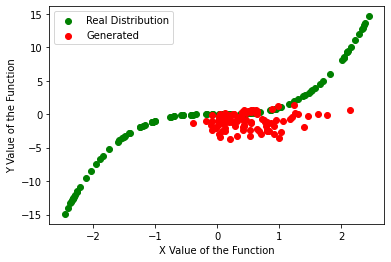

epoch:  5000


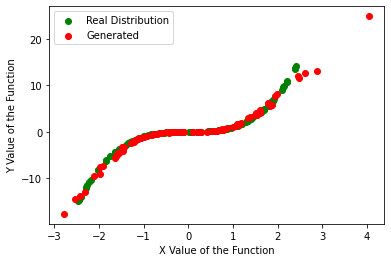

epoch:  10000


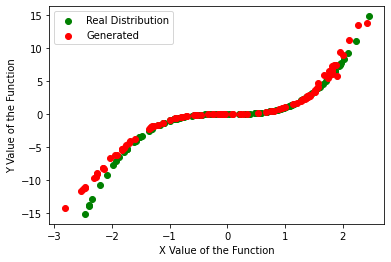

epoch:  15000


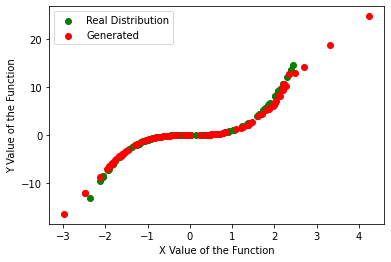

epoch:  20000


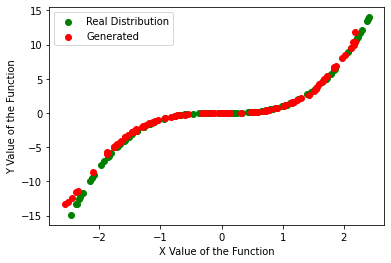

epoch:  25000


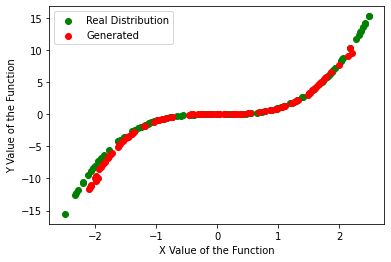

epoch:  30000


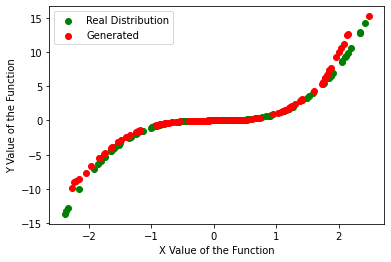

epoch:  35000


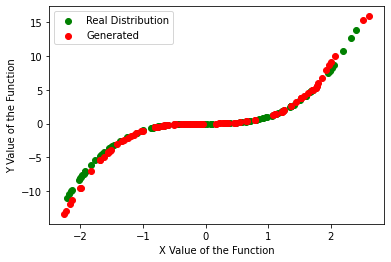

epoch:  40000


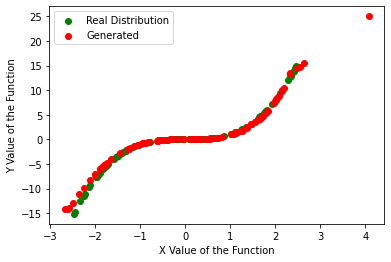

epoch:  45000


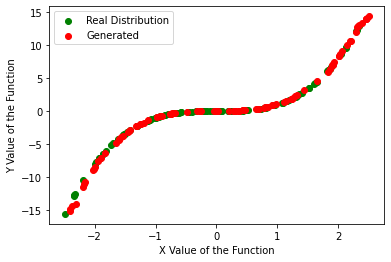

epoch:  50000


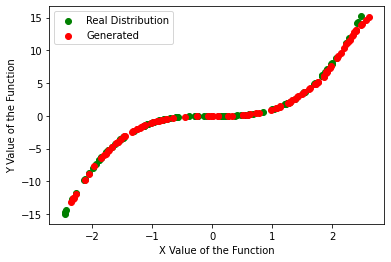

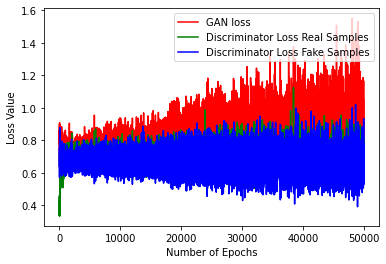

In [38]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_method(gen, dis, gan_architecture, latent)

## **Timeseries Test**

In [0]:
def real_timeseries_examples(n): 
  X_var = []
  X_func = []

  for i in range(n):
    X_var.append((i+1))

  for i in range(n):
    X_func.append(Intercontinental[i])

  X_var_array = np.asarray(X_var)
  X_var_array = X_var_array.reshape(n,1)
  X_func_array = np.asarray(X_func)
  X_func_array = X_func_array.reshape(n,1)

  X = hstack((X_var_array, X_func_array))
  y= ones((n,1))

  return X,y 

In [0]:
def snapshot_timeseries(epoch, gen, dis, latent, n=2500):
#generate real samples and their corresponding labels 
  example_real, label_real = real_timeseries_examples(n)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = fake_examples(gen, latent, n)
#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_timeseries_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  batch_size=2500
  snapshot_value=5000
  
  #creation of lists to store the losses for the gan and discriminator on both the fake and real samples
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  #a loop to iterate through each epoch 
  for i in range(epochs):
    #creation of the real and fake examples
    example_real, label_real = real_timeseries_examples(int(batch_size/2))
    example_fake, label_fake = fake_examples(gen_architecture, latent, int(batch_size/2))
    #training the discriminator on the real and fake examples and storing the the losses 
    discriminator_history_real = dis_architecture.train_on_batch(example_real, label_real)
    discriminator_history_fake = dis_architecture.train_on_batch(example_fake, label_fake)
    #appending the losses form each epoch to the previously created lists 
    discriminator_loss_real.append(np.mean(discriminator_history_real))
    discriminator_loss_fake.append(np.mean(discriminator_history_fake))
    #generating the latent points that will be the input to the gan 
    gan_input = latent_points(latent, batch_size)
    #creating the labels for the samples that are fed to the gan
    gan_labels = ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)
    #appending the gan loss to the previously created list
    gan_loss.append(np.mean(gan_history))
    #creation of a condition to visualize the performance of the gan after 1st epoch and every 5000 epochs after that
    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot_timeseries(i,gen_architecture,dis_architecture,latent)
  #using the previously created method to visualize the loss of the discriminator and gan  
  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


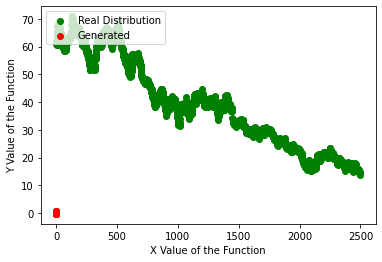

epoch:  5000


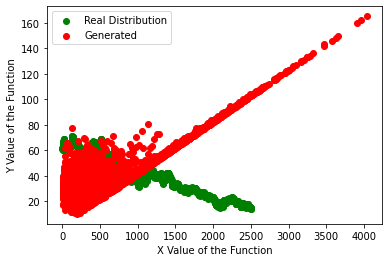

epoch:  10000


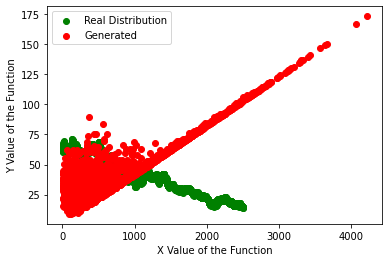

epoch:  15000


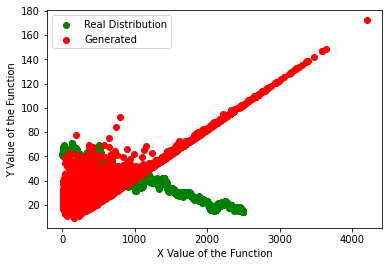

KeyboardInterrupt: ignored

In [105]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_timeseries_method(gen, dis, gan_architecture, latent)

## **Normalised Timeseries Test**

In [0]:
def real_normalised_timeseries_examples(n): 
  X_var = []
  X_func = []

  for i in range(n): 
    X_var.append(i+1)

  for i in range(n): 
    X_func.append(normalized[i])
    
  X_var_array = np.asarray(X_var)
  X_var_array = X_var_array.reshape(n,1)
  X_func_array = np.asarray(X_func)
  X_func_array = X_func_array.reshape(n,1)

  X = hstack((X_var_array, X_func_array))
  y= ones((n,1))

  return X,y 

In [0]:
def snapshot(epoch, gen, dis, latent, n=2500):
#generate real samples and their corresponding labels 
  example_real, label_real = real_normalised_timeseries_examples(n)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = fake_examples(gen, latent, n)

#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_normalised_timeseries_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  batch_size=2500
  snapshot_value=5000
  #creation of lists to store the losses for the gan and discriminator on both the fake and real samples
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  #a loop to iterate through each epoch 
  for i in range(epochs):
    #creation of the real and fake examples
    example_real, label_real = real_normalised_timeseries_examples(int(batch_size/2))
    example_fake, label_fake = fake_examples(gen_architecture, latent, int(batch_size/2))
    #training the discriminator on the real and fake examples and storing the the losses 
    discriminator_history_real = dis_architecture.train_on_batch(example_real, label_real)
    discriminator_history_fake = dis_architecture.train_on_batch(example_fake, label_fake)
    #appending the losses form each epoch to the previously created lists 
    discriminator_loss_real.append(np.mean(discriminator_history_real))
    discriminator_loss_fake.append(np.mean(discriminator_history_fake))
    #generating the latent points that will be the input to the gan 
    gan_input = latent_points(latent, batch_size)
    #creating the labels for the samples that are fed to the gan
    gan_labels = ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)
    #appending the gan loss to the previously created list
    gan_loss.append(np.mean(gan_history))
    #creation of a condition to visualize the performance of the gan after 1st epoch and every 5000 epochs after that
    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot(i,gen_architecture,dis_architecture,latent)
  #using the previously created method to visualize the loss of the discriminator and gan  
  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


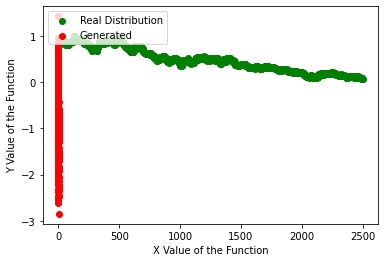

epoch:  5000


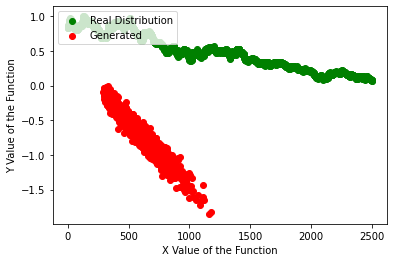

epoch:  10000


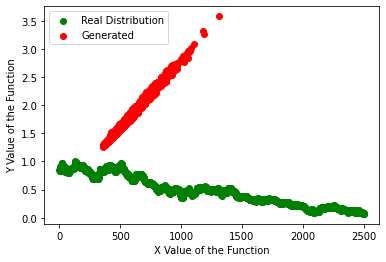

epoch:  15000


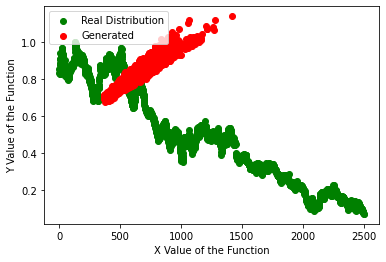

epoch:  20000


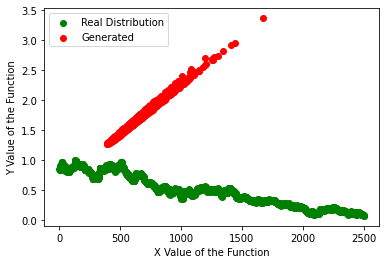

epoch:  25000


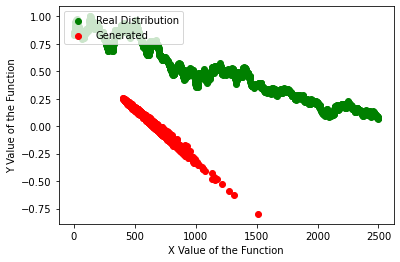

epoch:  30000


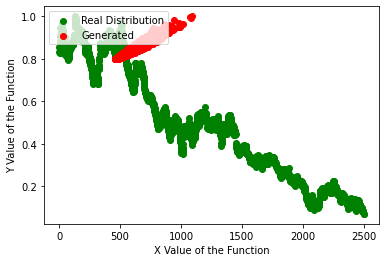

epoch:  35000


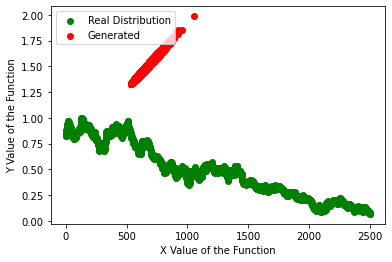

KeyboardInterrupt: ignored

In [144]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_normalised_timeseries_method(gen, dis, gan_architecture, latent)

## **Normalised and Constrained Timeseries Test**

In [0]:
def real_constrained_timeseries_examples(n):

  X_var = []
  X_func = []

  for i in range(n): 
    X_var.append((i+1)/50)

  for i in range(n):
    X_func.append(normalized[i])

  X_var_array = np.asarray(X_var)
  X_var_array = X_var_array.reshape(n,1)
  X_func_array = np.asarray(X_func)
  X_func_array = X_func_array.reshape(n,1)

  X = hstack((X_var_array, X_func_array))
  y= ones((n,1))

  return X,y 

In [0]:
def snapshot_constrained(epoch, gen, dis, latent, n=100):
#generate real samples and their corresponding labels 
  example_real, label_real = real_constrained_timeseries_examples(n)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = fake_examples(gen, latent, n)
#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_normalised_constrained_timeseries_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  batch_size=100
  snapshot_value=5000
  #creation of lists to store the losses for the gan and discriminator on both the fake and real samples
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  #a loop to iterate through each epoch 
  for i in range(epochs):
    #creation of the real and fake examples
    example_real, label_real = real_constrained_timeseries_examples(int(batch_size/2))
    example_fake, label_fake = fake_examples(gen_architecture, latent, int(batch_size/2))
    #training the discriminator on the real and fake examples and storing the the losses 
    discriminator_history_real = dis_architecture.train_on_batch(example_real, label_real)
    discriminator_history_fake = dis_architecture.train_on_batch(example_fake, label_fake)
    #appending the losses form each epoch to the previously created lists 
    discriminator_loss_real.append(np.mean(discriminator_history_real))
    discriminator_loss_fake.append(np.mean(discriminator_history_fake))
    #generating the latent points that will be the input to the gan 
    gan_input = latent_points(latent, batch_size)
    #creating the labels for the samples that are fed to the gan
    gan_labels = ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)
    #appending the gan loss to the previously created list
    gan_loss.append(np.mean(gan_history))
    #creation of a condition to visualize the performance of the gan after 1st epoch and every 5000 epochs after that
    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot_constrained(i,gen_architecture,dis_architecture,latent)
  #using the previously created method to visualize the loss of the discriminator and gan  
  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


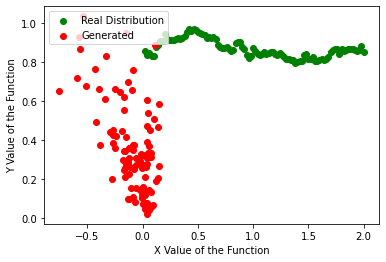

epoch:  5000


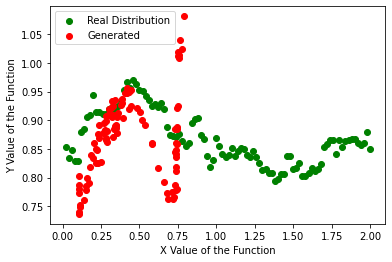

epoch:  10000


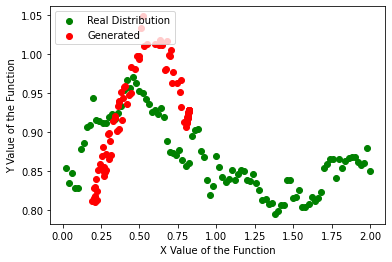

epoch:  15000


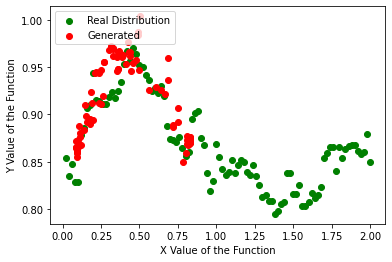

epoch:  20000


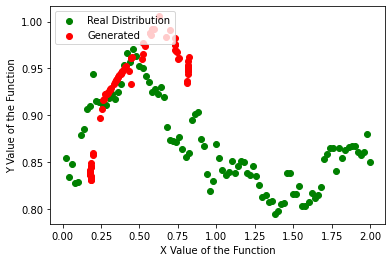

epoch:  25000


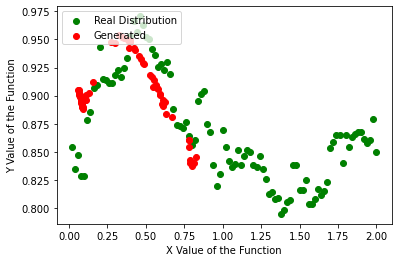

epoch:  30000


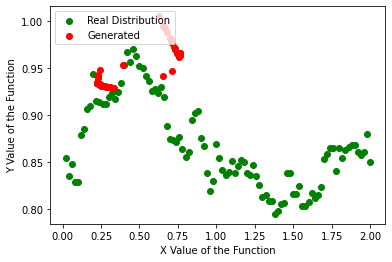

epoch:  35000


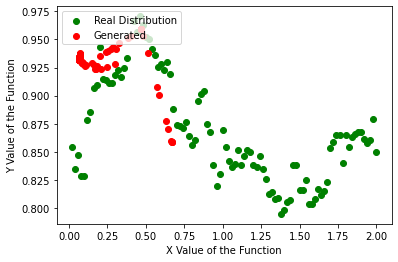

epoch:  40000


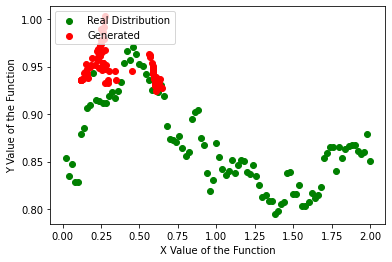

epoch:  45000


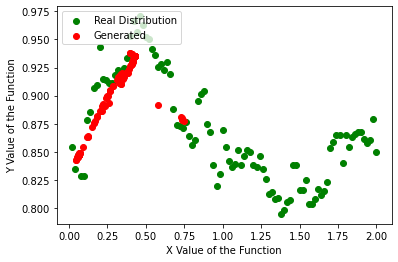

epoch:  50000


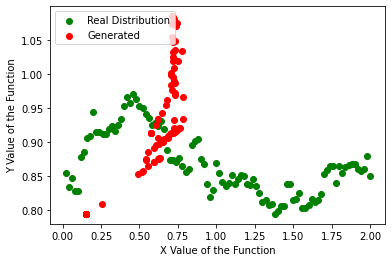

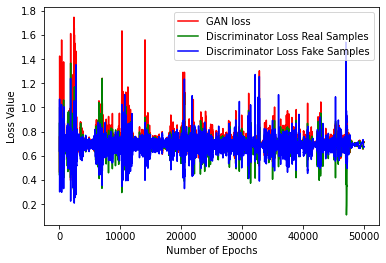

In [27]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_normalised_constrained_timeseries_method(gen, dis, gan_architecture, latent)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


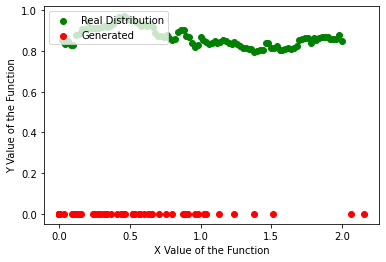

epoch:  5000 accuracy detecting a fake:  0.07999999821186066 accuracy detecting a real example:  0.6399999856948853


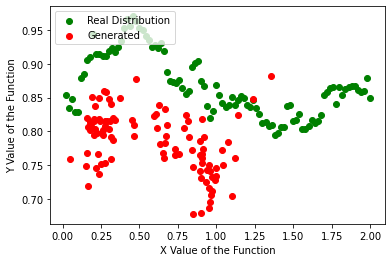

epoch:  10000 accuracy detecting a fake:  0.5699999928474426 accuracy detecting a real example:  0.3100000023841858


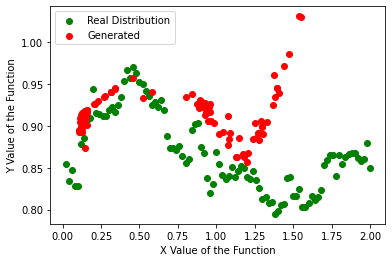

epoch:  15000 accuracy detecting a fake:  0.699999988079071 accuracy detecting a real example:  0.15000000596046448


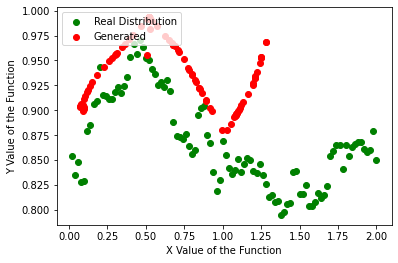

epoch:  20000 accuracy detecting a fake:  0.12999999523162842 accuracy detecting a real example:  0.36000001430511475


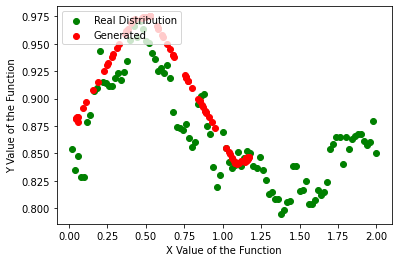

epoch:  25000 accuracy detecting a fake:  0.17000000178813934 accuracy detecting a real example:  0.25999999046325684


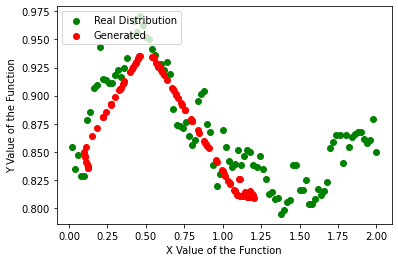

epoch:  30000 accuracy detecting a fake:  1.0 accuracy detecting a real example:  0.009999999776482582


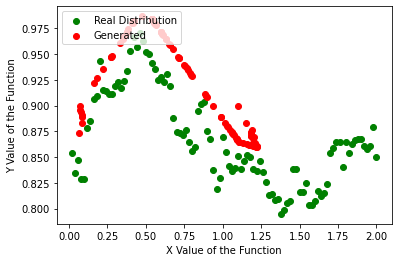

epoch:  35000 accuracy detecting a fake:  1.0 accuracy detecting a real example:  0.23000000417232513


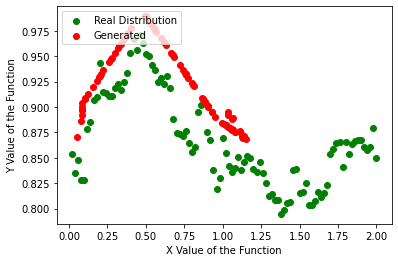

epoch:  40000 accuracy detecting a fake:  1.0 accuracy detecting a real example:  0.10999999940395355


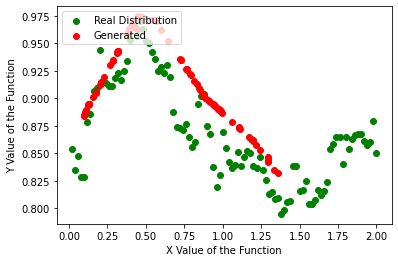

epoch:  45000 accuracy detecting a fake:  1.0 accuracy detecting a real example:  0.0


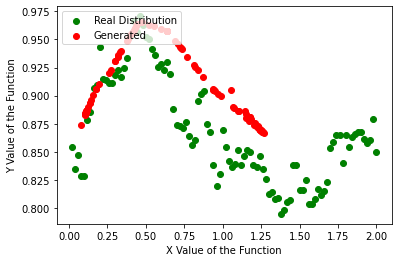

epoch:  50000 accuracy detecting a fake:  0.05999999865889549 accuracy detecting a real example:  0.699999988079071


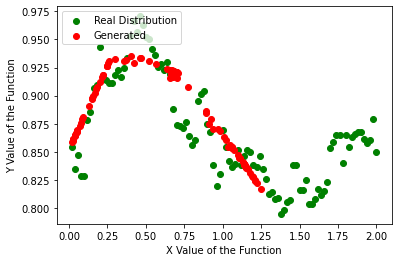

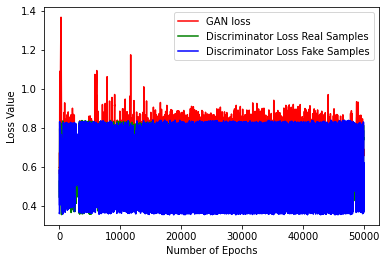

In [0]:
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_normalised_constrained_timeseries_method(gen, dis, gan_architecture, latent)

# **Wasserstein GAN**

In [0]:
#the loss function needed to implement Wasserstein loss 
def Wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true * y_pred)

  

In [0]:
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


In [0]:
def Wasserstein_gen_method(latent, num_outputs=2):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  return model
  #Generator model required for GAN model 2
  """
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))

  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  #Generator model required for GAN model 3
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  

def Wasserstein_dis_method(num_inputs=2):
  const = ClipConstraint(0.2)
  model = Sequential()
  model.add(Dense(40, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(20, activation='relu', kernel_constraint = const))
  model.add(Dense(5, activation='relu', kernel_constraint = const))
  model.add(Dense(1, activation='linear'))
  opt = RMSprop(lr=0.00008)
  model.compile(loss=Wasserstein_loss, optimizer=opt, metrics=['accuracy'])
  return model
 #Discriminator model required for GAN model 2
  """
  model.add(Dense(40, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(20, activation='relu', kernel_constraint = const))
  model.add(Dense(5, activation='relu', kernel_constraint = const))
  model.add(Dense(1, activation='linear'))
  opt = RMSprop(lr=0.00008)
  model.compile(loss=Wasserstein_loss, optimizer=opt, metrics=['accuracy'])


  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', kernel_constraint = const, input_dim=num_inputs))
  model.add(Dense(15, activation='relu',  kernel_constraint = const))
  model.add(Dense(10, activation='relu',  kernel_constraint = const))
  model.add(Dense(1, activation='linear'))
  """
  #Discriminator model required for GAN model 3 
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu', kernel_constraint = const))
  model.add(Dense(30, activation='relu', kernel_constraint = const))
  model.add(Dense(20, activation='relu', kernel_constraint = const))
  model.add(Dense(10, activation='relu', kernel_constraint = const))
  model.add(Dense(1, activation='linear'))
  opt = RMSprop(lr=0.00008)
  model.compile(loss=Wasserstein_loss, optimizer=opt, metrics=['accuracy'])
  """
  

def Wasserstein_gan_method(gen, dis):
  dis.trainable =False
  model = Sequential()
  model.add(gen)
  model.add(dis)
  opt = RMSprop(lr=0.00008)
  model.compile(loss=Wasserstein_loss, optimizer=opt)
  return model

In [0]:
"""
this method is used when stress testing the gan on various mathematical functions
the value of of x_func can be replaced with any function to test the working of
the GAN architecture. The examples created here are used to train the discriminator 
to recognise what real examples look like
"""
def Wasserstein_real_examples(n): 
#this line creates the random numbers that will be used within the x_func variable
  X_var = -2.5+(2.5-(-2.5))*rand(1,n)
  #X_var = np.arange(0, n*0.1,0.1)
#the x_func variable is used to model the mathematical function we wish to generate 
  X_func = X_var * X_var * X_var
  #X_func = (X_var + 3)*((X_var -2)**2)*((X_var+1)**3)
  #X_func = np.sin(X_var)
#the variables have to be reshaped so that they may be stacked into an array 
  X_var = X_var.reshape(n,1)
  X_func = X_func.reshape(n,1)
#hstack is used to ensure that the x_var corresponds to x_func 
  X = hstack((X_var,X_func))
#we generate labels for the real examples in the form of ones
  y = -ones((n,1))
  return X,y
"""
the method below creates the points in latent space that will serve as the input 
to the generator model. The literature on GANs suggest that the best type of input 
for a GAN model's generator are random points from a gaussian distribution. 
"""
def Wasserstein_latent_points(latent, n):
#we use randn here as it returns random variables from a normal gaussian distribution 
  input_var = randn(latent*n)
  input_var = input_var.reshape(n,latent)
  return input_var
"""
we use 
"""
def Wasserstein_fake_examples(gen, latent,n):
  input_var = Wasserstein_latent_points(latent, n)
  X = gen.predict(input_var)
  y = ones((n,1))
  return X,y

In [0]:
def Wasserstein_snapshot(epoch, gen, dis, latent, n=100):
  example_real, label_real = Wasserstein_real_examples(n)
  example_fake, label_fake = Wasserstein_fake_examples(gen, latent, n)
  
  print("epoch: ", epoch+1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
def Wasserstein_training_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  discriminator_update=5
  batch_size=256
  snapshot_value=5000
  
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  for i in range(epochs):
    discriminator_loss_real_temp, discriminator_loss_fake_temp = list(), list()
    for j in range(discriminator_update): 
      example_real, label_real = Wasserstein_real_examples(int(batch_size/2))
      example_fake, label_fake = Wasserstein_fake_examples(gen_architecture, latent, int(batch_size/2))
      
      discriminator_history_real_temp = dis_architecture.train_on_batch(example_real, label_real)
      discriminator_history_fake_temp = dis_architecture.train_on_batch(example_fake, label_fake)

      discriminator_loss_real_temp.append((discriminator_history_real_temp))
      discriminator_loss_fake_temp.append((discriminator_history_fake_temp))

    discriminator_loss_real.append(np.mean(discriminator_loss_real_temp))
    discriminator_loss_fake.append(np.mean(discriminator_loss_fake_temp))

    gan_input = Wasserstein_latent_points(latent, batch_size)
    gan_labels = -ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)

    gan_loss.append(np.mean(gan_history))

    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      Wasserstein_snapshot(i,gen_architecture,dis_architecture,latent)

  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


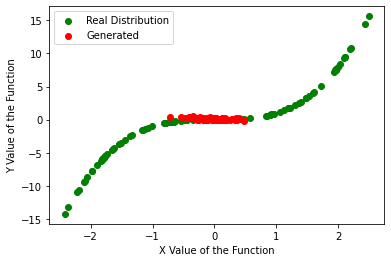

epoch:  5000


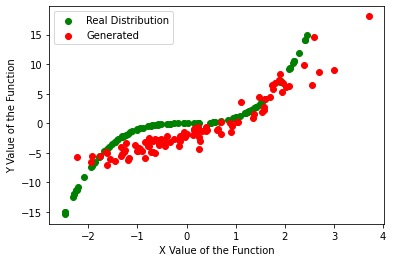

epoch:  10000


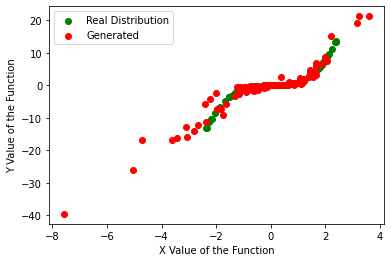

epoch:  15000


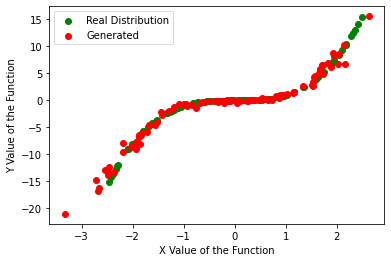

epoch:  20000


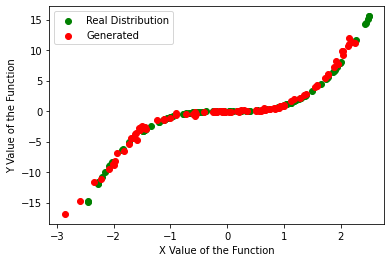

epoch:  25000


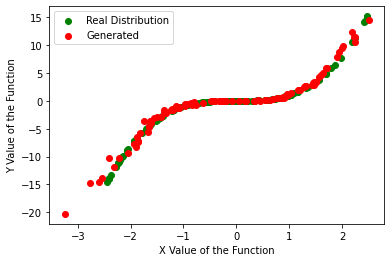

epoch:  30000


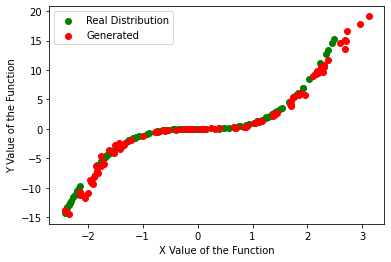

epoch:  35000


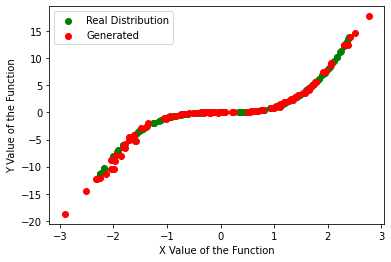

epoch:  40000


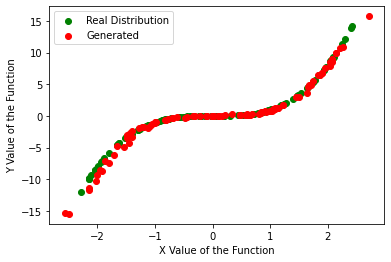

epoch:  45000


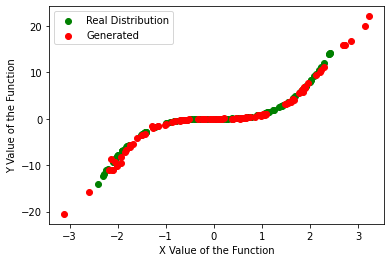

epoch:  50000


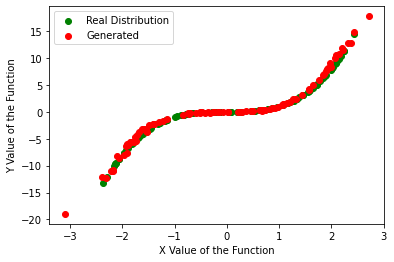

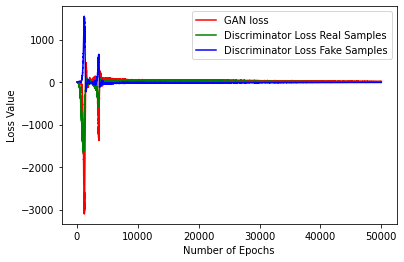

In [71]:
latent = 5
gen = Wasserstein_gen_method(latent)
dis = Wasserstein_dis_method()
gan_architecture = Wasserstein_gan_method(gen,dis)

Wasserstein_training_method(gen, dis, gan_architecture, latent)

## **Timeseries Test**

In [0]:
def real_timeseries_wass_examples(n): 
  X_var = []
  X_func = []

  for i in range(n):
    X_var.append((i+1))

  for i in range(n):
    X_func.append(Intercontinental[i])

  X_var_array = np.asarray(X_var)
  X_var_array = X_var_array.reshape(n,1)
  X_func_array = np.asarray(X_func)
  X_func_array = X_func_array.reshape(n,1)

  X = hstack((X_var_array, X_func_array))
  y= -ones((n,1))

  return X,y 

In [0]:
def snapshot_timeseries_wass(epoch, gen, dis, latent, n=100):
#generate real samples and their corresponding labels 
  example_real, label_real = real_timeseries_wass_examples(n)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = Wasserstein_fake_examples(gen, latent, n)
#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_timeseries_wass_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  discriminator_update=5
  batch_size=100
  snapshot_value=5000
  
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  for i in range(epochs):
    discriminator_loss_real_temp, discriminator_loss_fake_temp = list(), list()
    for j in range(discriminator_update): 
      example_real, label_real = real_timeseries_wass_examples(int(batch_size/2))
      example_fake, label_fake = Wasserstein_fake_examples(gen_architecture, latent, int(batch_size/2))
      
      discriminator_history_real_temp = dis_architecture.train_on_batch(example_real, label_real)
      discriminator_history_fake_temp = dis_architecture.train_on_batch(example_fake, label_fake)

      discriminator_loss_real_temp.append((discriminator_history_real_temp))
      discriminator_loss_fake_temp.append((discriminator_history_fake_temp))

    discriminator_loss_real.append(np.mean(discriminator_loss_real_temp))
    discriminator_loss_fake.append(np.mean(discriminator_loss_fake_temp))

    gan_input = Wasserstein_latent_points(latent, batch_size)
    gan_labels = -ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)

    gan_loss.append(np.mean(gan_history))

    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot_timeseries_wass(i,gen_architecture,dis_architecture,latent)

  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


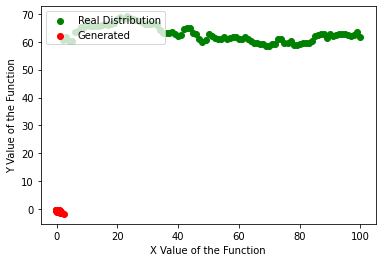

epoch:  2500


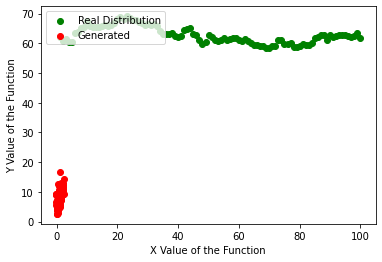

epoch:  5000


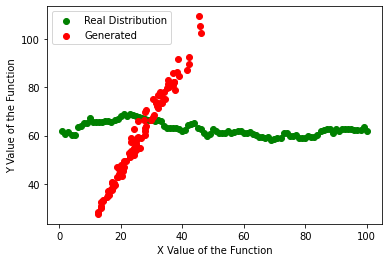

epoch:  7500


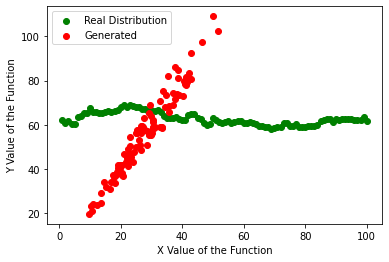

epoch:  10000


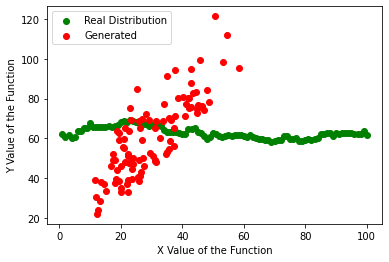

epoch:  12500


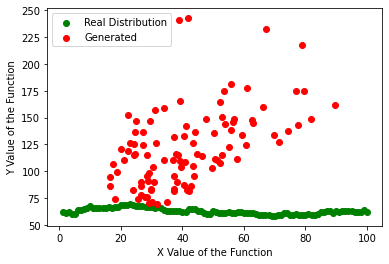

epoch:  15000


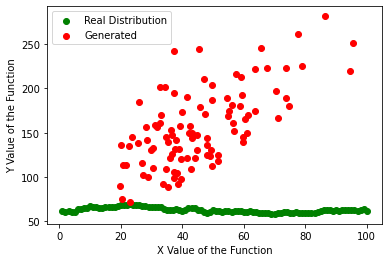

epoch:  17500


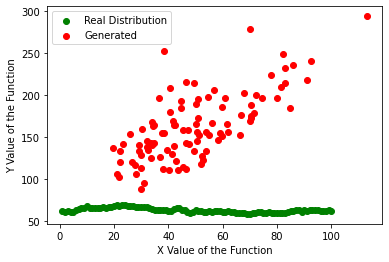

epoch:  20000


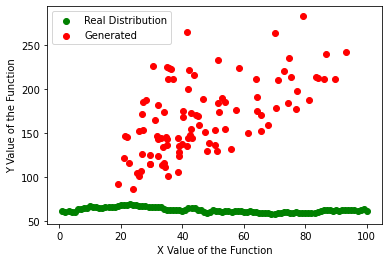

epoch:  22500


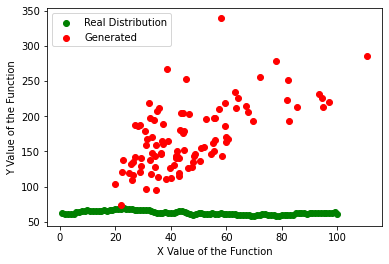

epoch:  25000


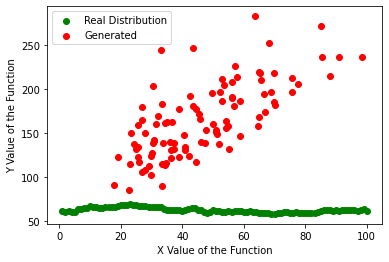

epoch:  27500


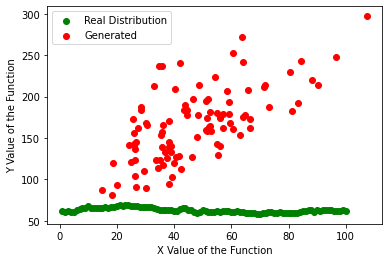

epoch:  30000


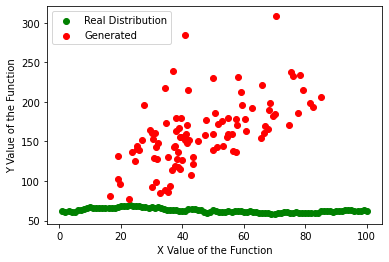

epoch:  32500


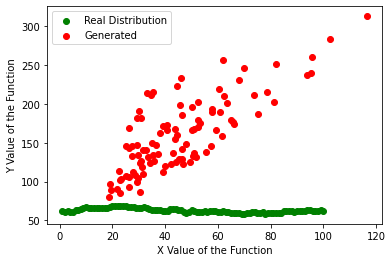

epoch:  35000


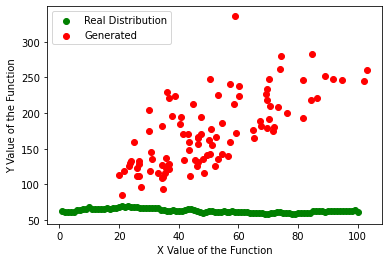

KeyboardInterrupt: ignored

In [84]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = Wasserstein_gen_method(latent)
dis = Wasserstein_dis_method()
gan_architecture = Wasserstein_gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_timeseries_wass_method(gen, dis, gan_architecture, latent)

## **Normalised Timeseries Test**

In [0]:
def real_normalised_timeseries_wass_examples(n): 
  X_var = []
  X_func = []

  for i in range(n): 
    X_var.append(i+1)

  for i in range(n): 
    X_func.append(normalized[i])
    
  X_var_array = np.asarray(X_var)
  X_var_array = X_var_array.reshape(n,1)
  X_func_array = np.asarray(X_func)
  X_func_array = X_func_array.reshape(n,1)

  X = hstack((X_var_array, X_func_array))
  y= -ones((n,1))

  return X,y 

In [0]:
def snapshot_normalised_wass(epoch, gen, dis, latent, n=100):
#generate real samples and their corresponding labels 
  example_real, label_real = real_normalised_timeseries_wass_examples(n)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = Wasserstein_fake_examples(gen, latent, n)
#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_normalised_timeseries_wass_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  discriminator_update=5
  batch_size=100
  snapshot_value=5000
  
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  for i in range(epochs):
    discriminator_loss_real_temp, discriminator_loss_fake_temp = list(), list()
    for j in range(discriminator_update): 
      example_real, label_real = real_normalised_timeseries_wass_examples(int(batch_size/2))
      example_fake, label_fake = Wasserstein_fake_examples(gen_architecture, latent, int(batch_size/2))
      
      discriminator_history_real_temp = dis_architecture.train_on_batch(example_real, label_real)
      discriminator_history_fake_temp = dis_architecture.train_on_batch(example_fake, label_fake)

      discriminator_loss_real_temp.append((discriminator_history_real_temp))
      discriminator_loss_fake_temp.append((discriminator_history_fake_temp))

    discriminator_loss_real.append(np.mean(discriminator_loss_real_temp))
    discriminator_loss_fake.append(np.mean(discriminator_loss_fake_temp))

    gan_input = Wasserstein_latent_points(latent, batch_size)
    gan_labels = -ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)

    gan_loss.append(np.mean(gan_history))

    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot_normalised_wass(i,gen_architecture,dis_architecture,latent)

  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


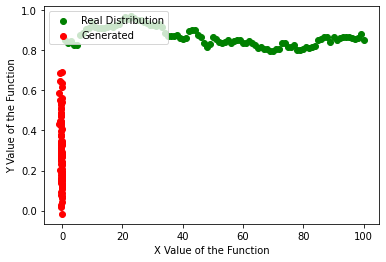

epoch:  1000


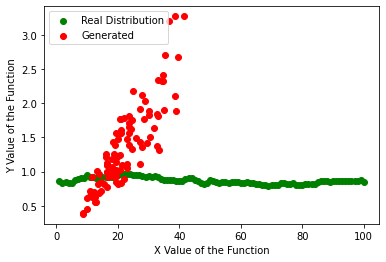

epoch:  2000


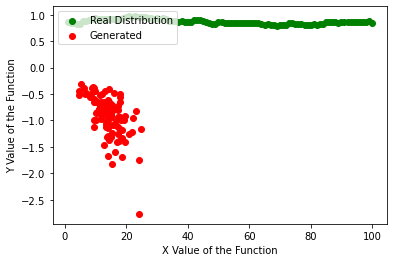

epoch:  3000


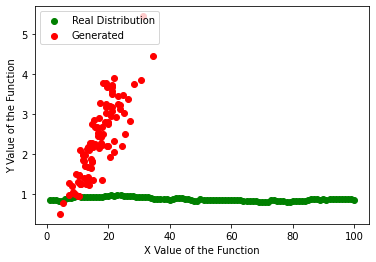

epoch:  4000


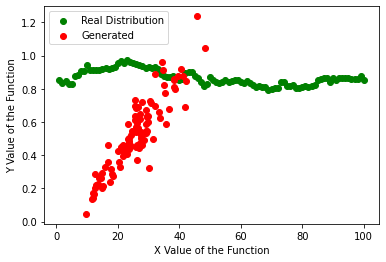

epoch:  5000


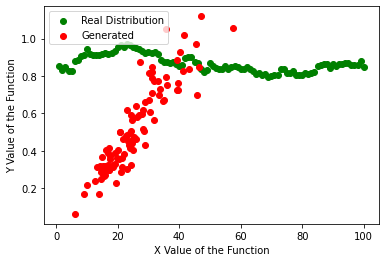

epoch:  6000


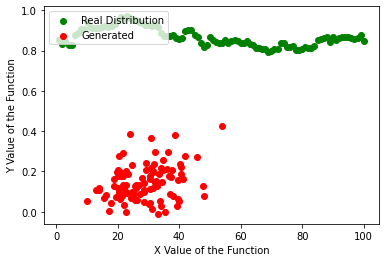

epoch:  7000


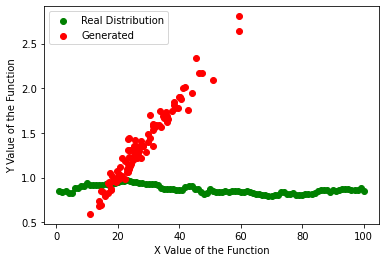

epoch:  8000


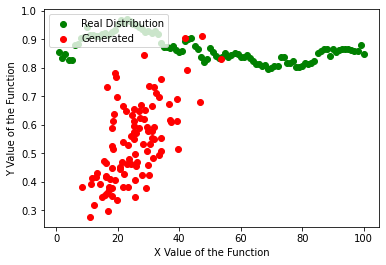

epoch:  9000


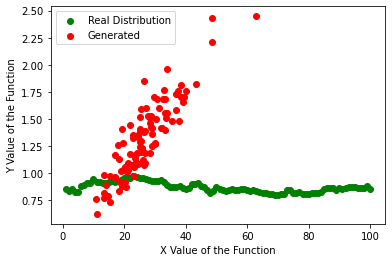

epoch:  10000


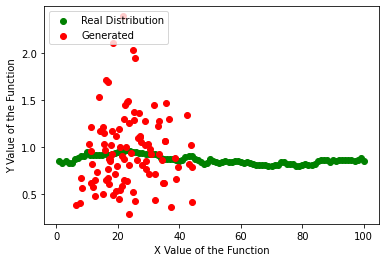

epoch:  11000


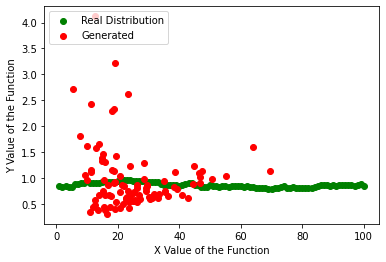

epoch:  12000


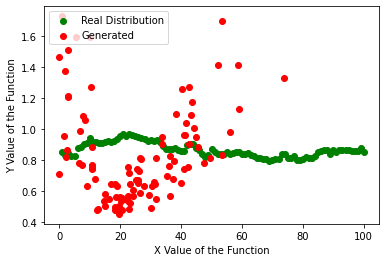

epoch:  13000


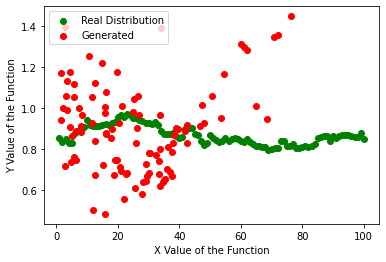

epoch:  14000


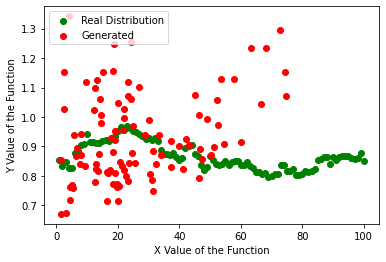

epoch:  15000


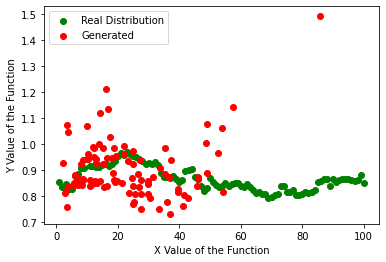

epoch:  16000


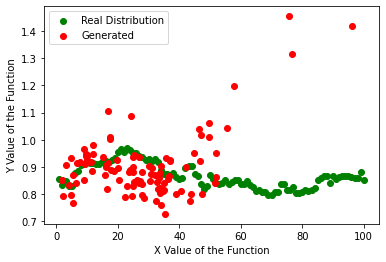

epoch:  17000


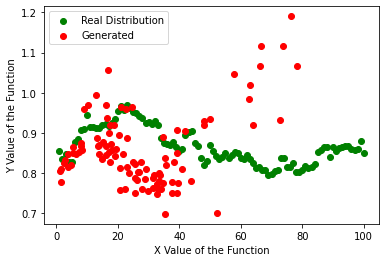

epoch:  18000


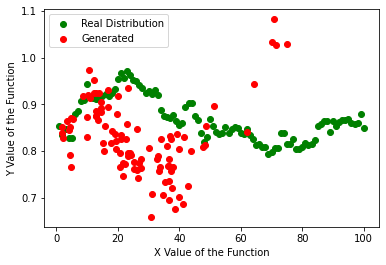

epoch:  19000


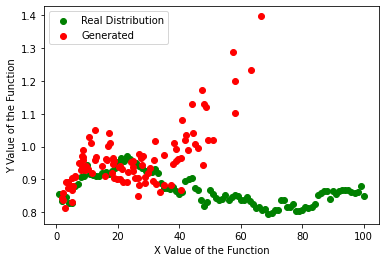

epoch:  20000


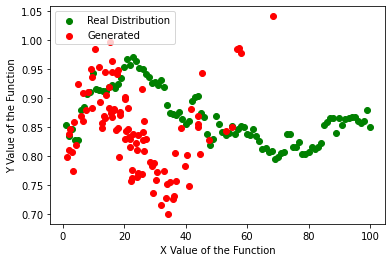

epoch:  21000


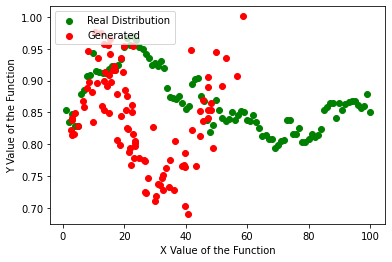

epoch:  22000


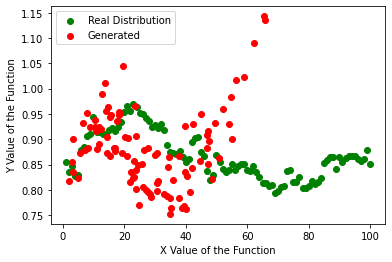

epoch:  23000


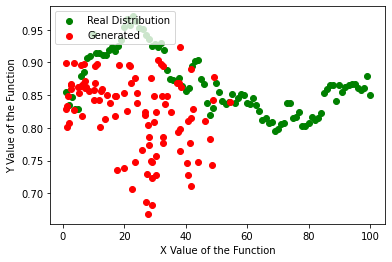

epoch:  24000


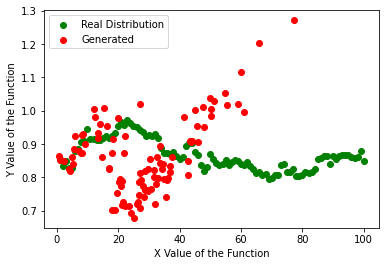

epoch:  25000


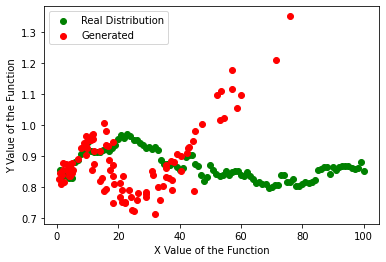

epoch:  26000


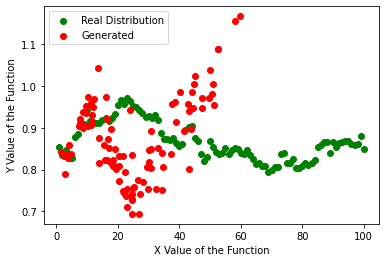

epoch:  27000


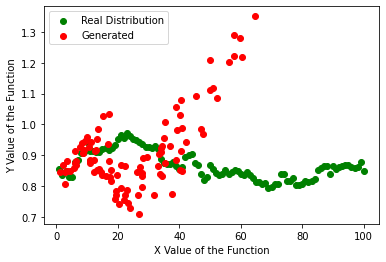

epoch:  28000


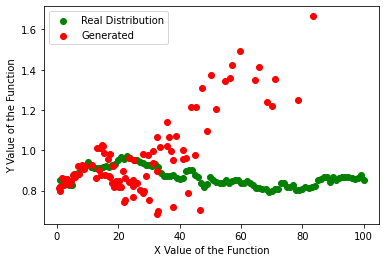

epoch:  29000


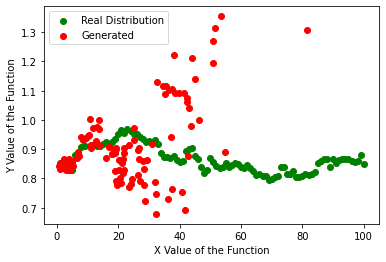

epoch:  30000


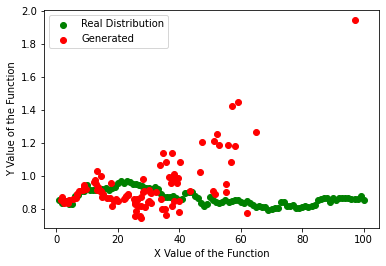

epoch:  31000


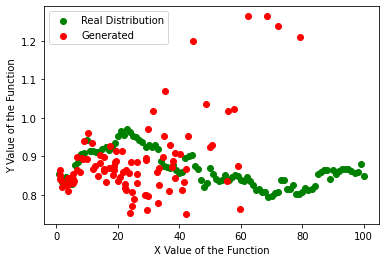

epoch:  32000


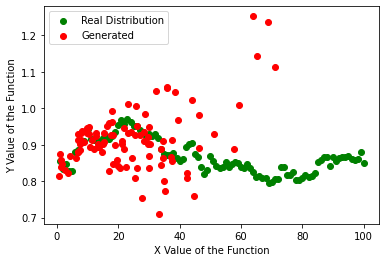

epoch:  33000


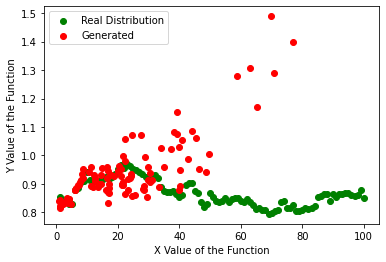

epoch:  34000


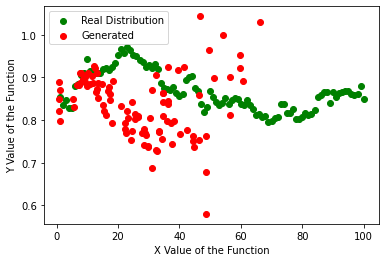

epoch:  35000


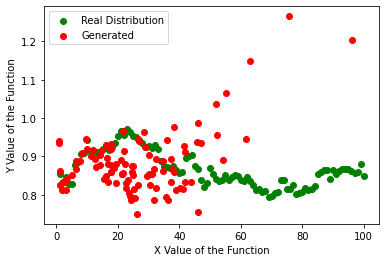

epoch:  36000


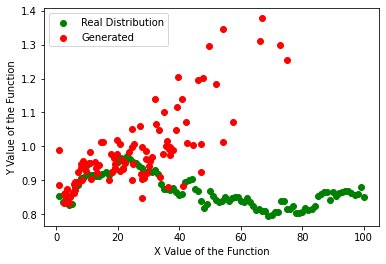

epoch:  37000


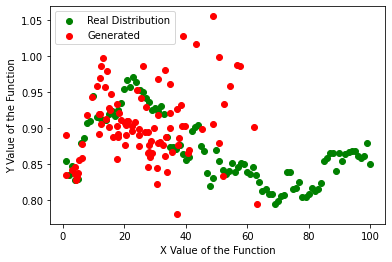

epoch:  38000


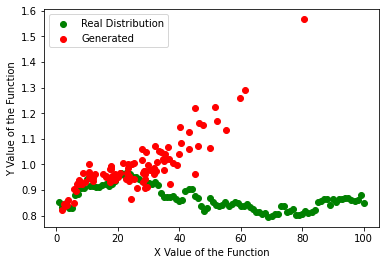

epoch:  39000


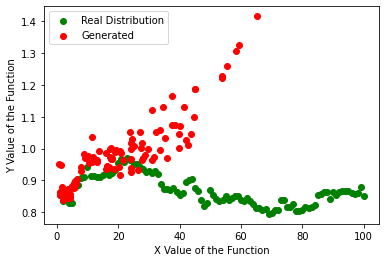

epoch:  40000


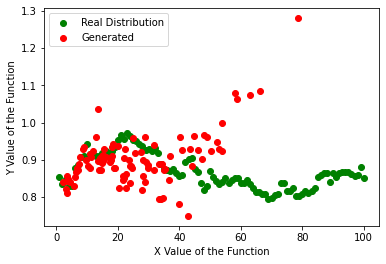

epoch:  41000


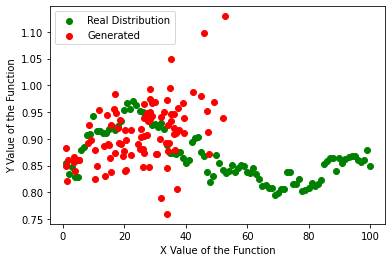

epoch:  42000


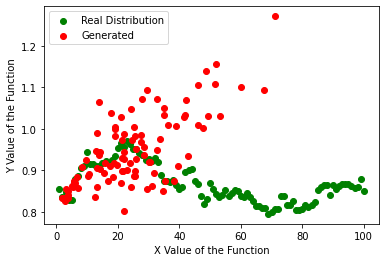

epoch:  43000


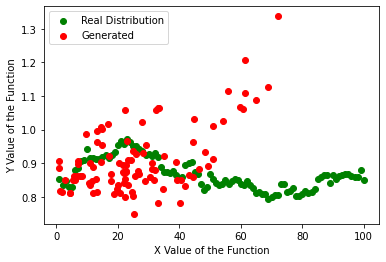

epoch:  44000


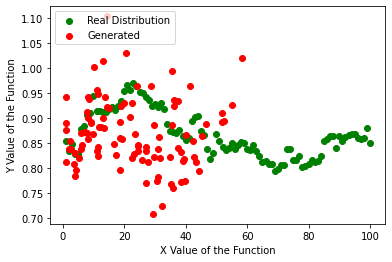

epoch:  45000


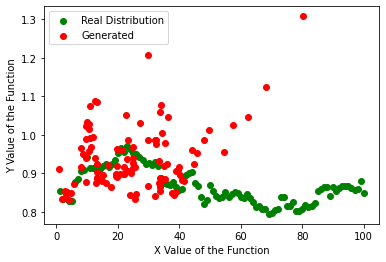

epoch:  46000


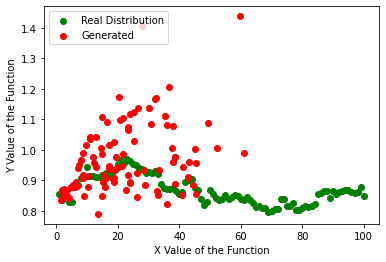

epoch:  47000


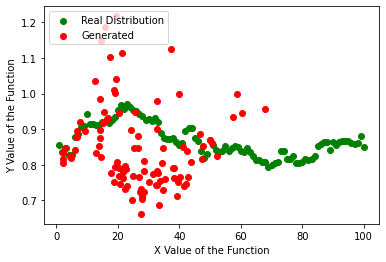

epoch:  48000


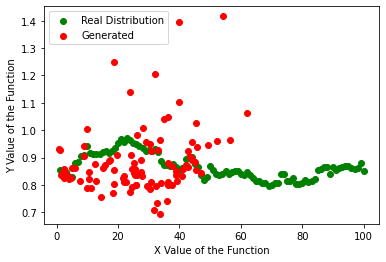

epoch:  49000


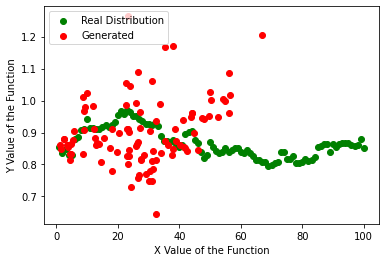

epoch:  50000


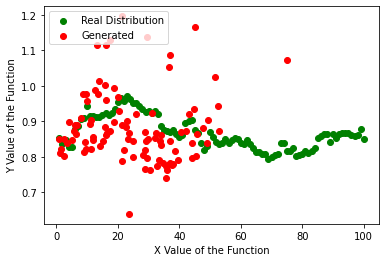

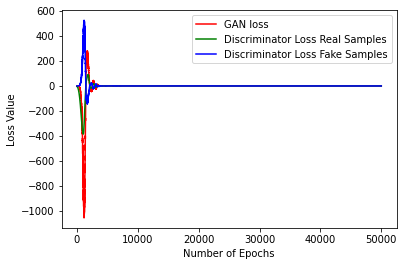

In [121]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = Wasserstein_gen_method(latent)
dis = Wasserstein_dis_method()
gan_architecture = Wasserstein_gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_normalised_timeseries_wass_method(gen, dis, gan_architecture, latent)

## **Normalised and Constrained Timeseries Test**

In [0]:
def real_constrained_timeseries_wass_examples(n):

  X_var = []
  X_func = []

  for i in range(n): 
    X_var.append((i+1)/50)

  for i in range(n):
    X_func.append(normalized[i])

  X_var_array = np.asarray(X_var)
  X_var_array = X_var_array.reshape(n,1)
  X_func_array = np.asarray(X_func)
  X_func_array = X_func_array.reshape(n,1)

  X = hstack((X_var_array, X_func_array))
  y= -ones((n,1))

  return X,y 

In [0]:
def snapshot_constrained_wass(epoch, gen, dis, latent, n=100):
#generate real samples and their corresponding labels 
  example_real, label_real = real_constrained_timeseries_wass_examples(n)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = Wasserstein_fake_examples(gen, latent, n)
#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
#this method is used to train the GAN and update the discriminator independtly to aid in training the gan
def training_normalised_constrained_timeseries_wass_method(gen_architecture, dis_architecture, gan_architecture, latent):
  
  epochs=50000
  discriminator_update=2
  batch_size=100
  snapshot_value=5000
  
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()
  for i in range(epochs):
    discriminator_loss_real_temp, discriminator_loss_fake_temp = list(), list()
    for j in range(discriminator_update): 
      example_real, label_real = real_constrained_timeseries_wass_examples(int(batch_size/2))
      example_fake, label_fake = Wasserstein_fake_examples(gen_architecture, latent, int(batch_size/2))
      
      discriminator_history_real_temp = dis_architecture.train_on_batch(example_real, label_real)
      discriminator_history_fake_temp = dis_architecture.train_on_batch(example_fake, label_fake)

      discriminator_loss_real_temp.append((discriminator_history_real_temp))
      discriminator_loss_fake_temp.append((discriminator_history_fake_temp))

    discriminator_loss_real.append(np.mean(discriminator_loss_real_temp))
    discriminator_loss_fake.append(np.mean(discriminator_loss_fake_temp))

    gan_input = Wasserstein_latent_points(latent, batch_size)
    gan_labels = -ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)

    gan_loss.append(np.mean(gan_history))

    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot_constrained_wass(i,gen_architecture,dis_architecture,latent)

  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1


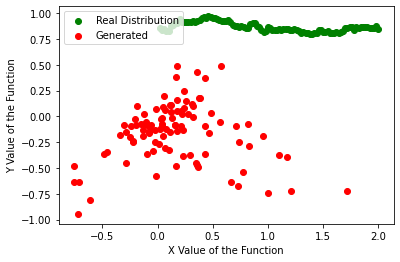

epoch:  5000


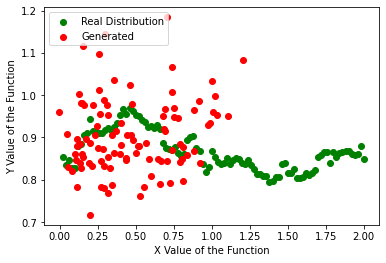

epoch:  10000


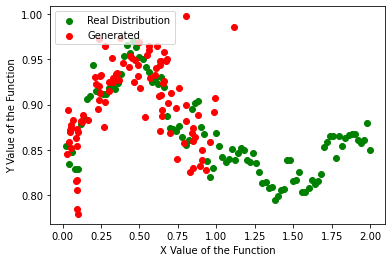

epoch:  15000


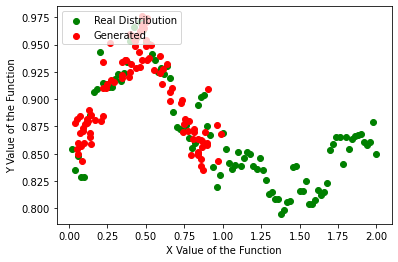

epoch:  20000


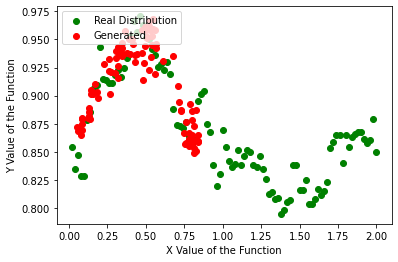

epoch:  25000


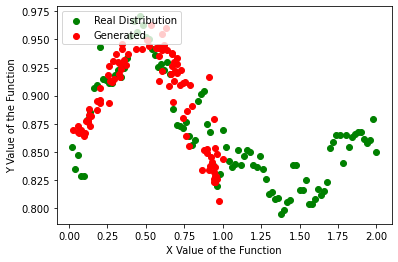

epoch:  30000


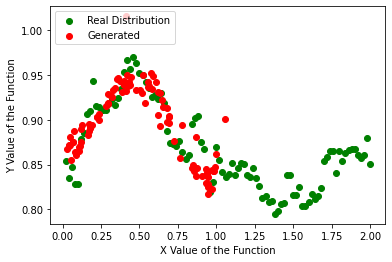

epoch:  35000


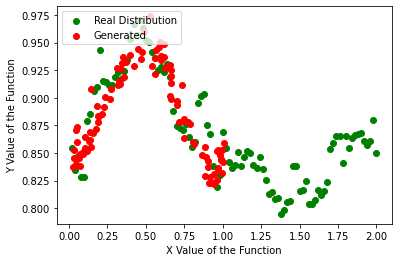

epoch:  40000


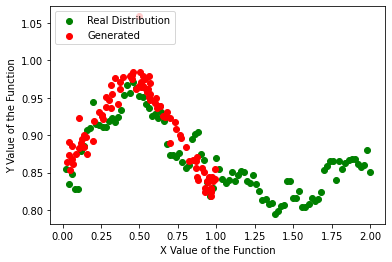

epoch:  45000


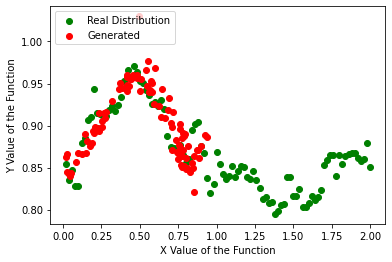

epoch:  50000


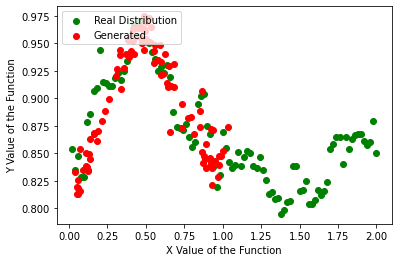

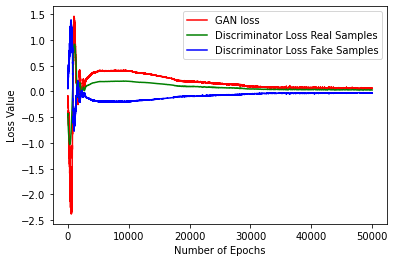

In [31]:
#assigning an arbitrary value to the latent space used to generate the points
latent = 5
gen = Wasserstein_gen_method(latent)
dis = Wasserstein_dis_method()
gan_architecture = Wasserstein_gan_method(gen,dis)
#using the training method to train the gan and update the discriminator
training_normalised_constrained_timeseries_wass_method(gen, dis, gan_architecture, latent)